In [12]:
import mariadb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from schema_creation import connection

conn = connection(password='8nqw$NS54Yh7FgWU', database="vet_clinic")
cur = conn.cursor()

connected to @localhost on port 3306


# Przygotuj wykres przedstawiający liczbę wizyt każdego dnia

<AxesSubplot:>

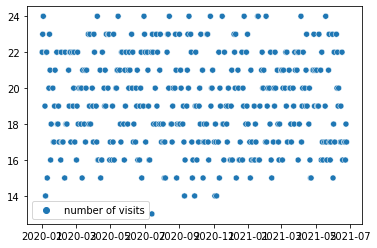

In [13]:
cur.execute('''select date(real_date), count(*) from visits where real_date is not null
group by year(real_date), month(real_date), day(real_date);
''')

records = cur.fetchall()
dates = []
novs = []
for date, nov in records:
    dates.append(date)
    novs.append(nov)

df = pd.DataFrame(data={'number of visits': novs}, index=dates)
sns.scatterplot(data=df)

# Przygotuj wykres przedstawiający bilans zysków i strat kliniki.

# Stwórz listę zwierzaków najdłużej czekających na wizytę.

#